# Use Case 3: Hydrographic Statistics

In this example, we compute some useful hydrographic statistics. We show how to properly account for different grid cell volumes using weighted statistics. The computation is accelerated using dask.

In [1]:
# Setup environment:
import oceanspy as ospy

# Additional packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Start client for multiprocessing
from dask.distributed import Client
import warnings
import dask
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35280 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 257.77 GB


Open the oceandataset and compute the potential density anomaly:

In [2]:
od_snapshot = ospy.open_oceandataset.from_catalog('get_started')
od_snapshot = od_snapshot.compute.potential_density_anomaly()

Opening get_started.


/home/idies/miniconda3/lib/python3.7/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Small cutout from EGshelfIIseas2km_ASR_crop.
Citation:
 * Almansi et al., 2017 - JPO.
See also:
 * EGshelfIIseas2km_ASR_full: Full domain without variables to close budgets.
 * EGshelfIIseas2km_ASR_crop: Cropped domain with variables to close budgets.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


Make a temperature/salinity diagram.

Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.

Number of samples: 5,927,388



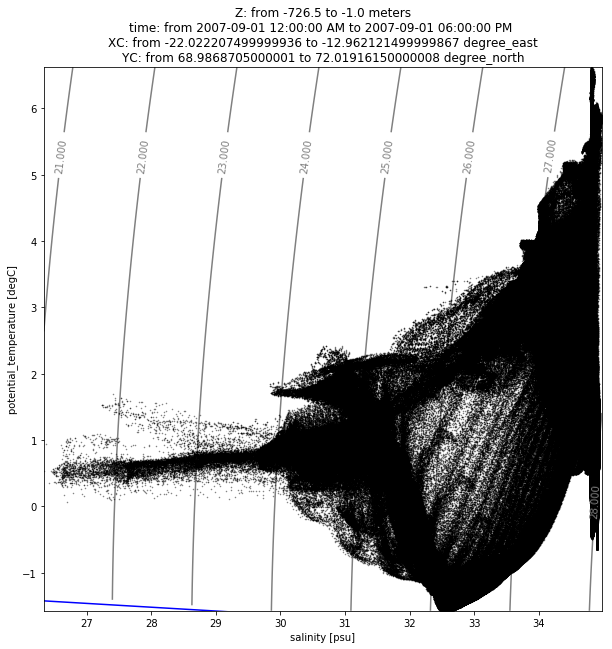

In [3]:
# The statistics are computed using these data.
fig = plt.figure(figsize=(10, 10))
od_snapshot.plot.TS_diagram(markersize=1, alpha=0.5)

# Print number of samples
n_samples = od_snapshot.dataset['Temp'].count().values
print("\nNumber of samples: {:,}\n".format(n_samples))

The temperature/salinity diagram shows the distribution of watermass types in terms of their hydrographic properties. Each dot represents a single grid cell in the dataset. We will compute statistics using this data to interpret the plot above.

## Binning and Parallelization
We define a function `bin_snapshot` to perform the binning we need to compute the volume-weighted statistics, or the mode of a variable. The use of the xarray stack method accelerates the groupby_bins task.

In [4]:
# Function for binning a single snapshot in time
# dat       = data array to bin (e.g., temperature distributed over 3D space)
# weights   = data array of the relative volumes of the cells in 3D space
# bin_edges = array of the edges of the bins (e.g. temperature bins)
# bin_mid   = array of the mid-points of the bins
def bin_snapshot(dat, weight, bin_edges, bin_mid):

    # Speed up by stacking over space
    dat = dat.stack(alldims=['X', 'Y', 'Z'])
    weight = weight.stack(alldims=['X', 'Y', 'Z'])

    # Bin the weight data into these variable bins
    # using the xarray groupby_bins method
    return weight.groupby_bins(dat.rename('groups'), bins=bin_edges,
                               labels=bin_mid, include_lowest=True).sum()

Pick `True` or `False` for the parallel variable below to run `bin_snapshot` with/without dask.

In [5]:
# Parallel switch
parallel = True

## Raw statistics
First compute and report some raw statistics using xarray, for comparison below. Because we ignore the different volumes of model grid cells, these statistics are not representative of the underlying fields.

In [6]:
# Compute and print raw statistics

# Define the percentiles required:
qiles = [0.01, 0.50, 0.99]

# Define the variables required:
var_list = ['Temp', 'S', 'Sigma0']

# Pretty print the results:
print("Raw statistics (not volume-weighted):")
print("%25s: %10s %10s %10s %10s %10s %10s %s"
      % ('Variable', 'mean', 'std', 'mode',
         '1', '50', '99', 'percentiles'))

# Loop over variables computing statistics using xarray methods.
# Variables need to be load because dask chunks are not compatible
# with xarray quantiles function.
for var in var_list:
    print("%25s:" % (od_snapshot.dataset[var].long_name), end=' ')

    # Data
    dats = getattr(od_snapshot.dataset, var).load()

    # Mean
    var_mean = dats.mean(keep_attrs=True)
    print("%10.4g" % (var_mean.values), end=' ')

    # Std
    var_std = dats.std(keep_attrs=True)
    print("%10.4g" % (var_std.values), end=' ')

    # Mode
    bin_edges = np.linspace(dats.min(), dats.max(), 512)
    bin_mid = (bin_edges[:-1]+bin_edges[1:])/2
    # Parallel switch
    if parallel:
        bin_snapshot_ = dask.delayed(bin_snapshot)

        # Needs to load first
        dat1 = [bin_snapshot_(dats.sel(time=time).load(),
                              xr.ones_like(dats).sel(time=time).load(),
                              bin_edges, bin_mid)
                for time in dats['time']]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dat1 = dask.compute(dat1)[0]
    else:
        dat1 = [bin_snapshot(dats.sel(time=time),
                             xr.ones_like(dats).sel(time=time),
                             bin_edges, bin_mid)
                for time in dats['time']]
    dat1 = xr.concat(dat1, 'time').sum('time')
    var_mode = dat1['groups_bins'].where(dat1 == dat1.max(), drop=True)
    print("%10.4g" % (var_mode.values), end=' ')

    # Qiles
    var_qiles = dats.quantile(qiles, keep_attrs=True)
    print("%10.4g %10.4g %10.4g %s"
          % (var_qiles.sel(quantile=qiles[0]).values,
             var_qiles.sel(quantile=qiles[1]).values,
             var_qiles.sel(quantile=qiles[2]).values,
             od_snapshot.dataset[var].units))

    del dats

Raw statistics (not volume-weighted):
                 Variable:       mean        std       mode          1         50         99 percentiles
    potential_temperature:     0.8009      1.366     0.1019     -1.421     0.4803      5.716 degC
                 salinity:      34.44     0.9865       34.9      30.68      34.89      34.93 psu
potential density anomaly:      27.59     0.7954      28.01      24.55      27.97      28.05 kg/m^3


## Weighted statistics
Compute the weighted mean (OceanSpy provides a method to do so).

In [7]:
od_snapshot = od_snapshot.compute.weighted_mean(varNameList=var_list)

# Print computed variables
print('\nVariables added:')
for var in od_snapshot.dataset.data_vars:
    if any([(var == v
             or var == f'weight_{v}'
             or var == f'w_mean_{v}')
            for v in var_list]):
        print('{:>15}: {} [{}]'.format(var,
                                       od_snapshot.dataset[var].long_name,
                                       od_snapshot.dataset[var].units))

Computing weighted_mean.

Variables added:
           Temp: potential_temperature [degC]
              S: salinity [psu]
         Sigma0: potential density anomaly [kg/m^3]
    w_mean_Temp: potential_temperature [degC]
    weight_Temp: Weights for average [s*m^2*m]
       w_mean_S: salinity [psu]
       weight_S: Weights for average [s*m^2*m]
  w_mean_Sigma0: potential density anomaly [kg/m^3]
  weight_Sigma0: Weights for average [s*m^2*m]


The weights used by OceanSpy have been stored in `od_snapshot`. The weights correspond to space-time volume elements $dx \; dy\; dz\; dt$ and hence have units of m$^3$s$^{-1}$. The variations in the weights are dominated by variations in grid cell volume, which comes from $dz$ (see below), although $dx$ and $dy$ are also important. As the timestep $dt$ is constant it isn't responsible for any variation in the weights. We can use the weights, for example, to color a TS-diagrams and better understand which temperature and salinity values are misrepresented using raw statistics.

Cutting out the oceandataset.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


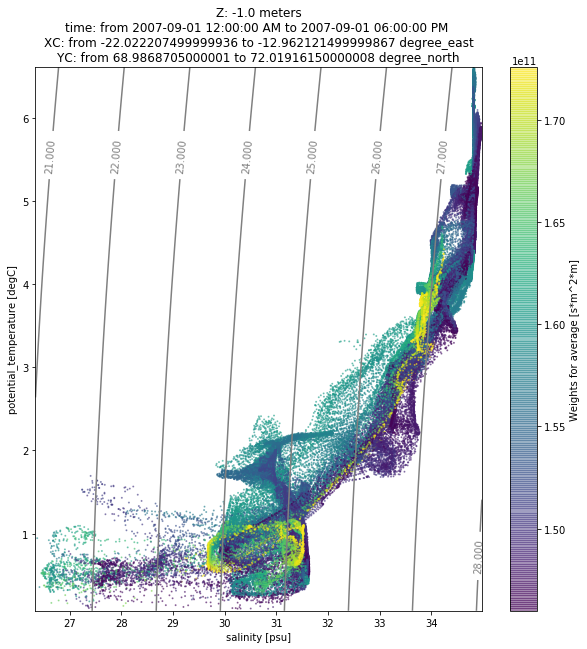

In [8]:
# Scatter plots are not optimized for large amount of samples,
# so the following TS-diagram only shows sea surface water.
fig = plt.figure(figsize=(10, 10))
ax = od_snapshot.plot.TS_diagram(s=1, alpha=0.5,
                                 colorName='weight_Temp',
                                 cutout_kwargs={'ZRange': 0,
                                                'dropAxes': True})

The vertical resolution of the model linearly increases from 1 to 15m in the upper 120m and is 15m thereafter. The following plots show that the weights of warmer and fresher water masses are overestimated in the raw statistics.

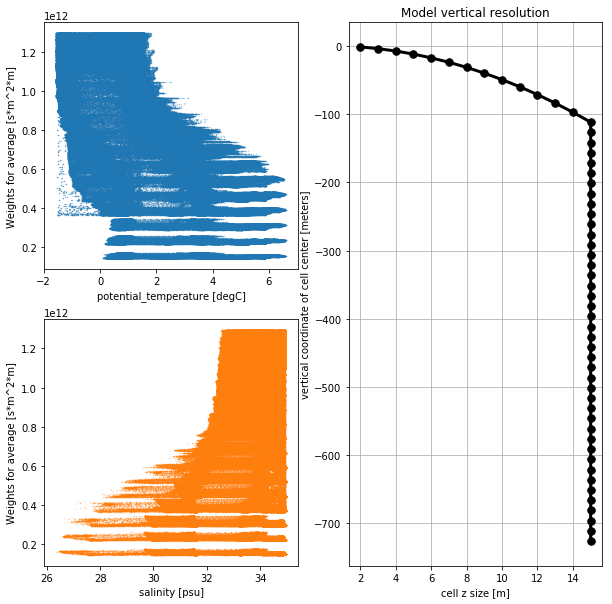

In [13]:
fig = plt.figure(figsize=(10, 10))

for i, (var, pos) in enumerate(zip(['Temp', 'S'], [221, 223])):
    ax = plt.subplot(pos)
    data = od_snapshot.dataset[var]
    weight = od_snapshot.dataset[f'weight_{var}']
    ax.plot(data.values.flatten(), weight.values.flatten(),
            '.', color=f'C{i}', alpha=0.5, markersize=0.5)
    ax.set_xlabel(f'{data.long_name} [{data.units}]')
    ax.set_ylabel(f'{weight.long_name} [{weight.units}]')
ax = plt.subplot(122)
drF = od_snapshot.dataset['drF']
Z = od_snapshot.dataset['Z']
line = ax.plot(drF, Z, '.-', color='k', linewidth=3, markersize=15)
xlab = ax.set_xlabel(f'{drF.long_name} [{drF.units}]')
ylab = ax.set_ylabel(f'{Z.long_name} [{Z.units}]')
tit = ax.set_title('Model vertical resolution')
ax.grid(True)

Next compute and report the same statistics as before but taking into account the different volumes of different grid cells. We also plot probability distribution and cumulative distribution functions.

Raw statistics (not volume-weighted):
                 Variable:       mean        std       mode          1         50         99 percentiles
    potential_temperature:     0.5422      1.033     0.1019     -1.435     0.3659      4.811 degC
                 salinity:       34.6     0.7318       34.9       31.5      34.89      34.92 psu
potential density anomaly:      27.75     0.5858      28.01      25.24      27.98      28.05 kg/m^3


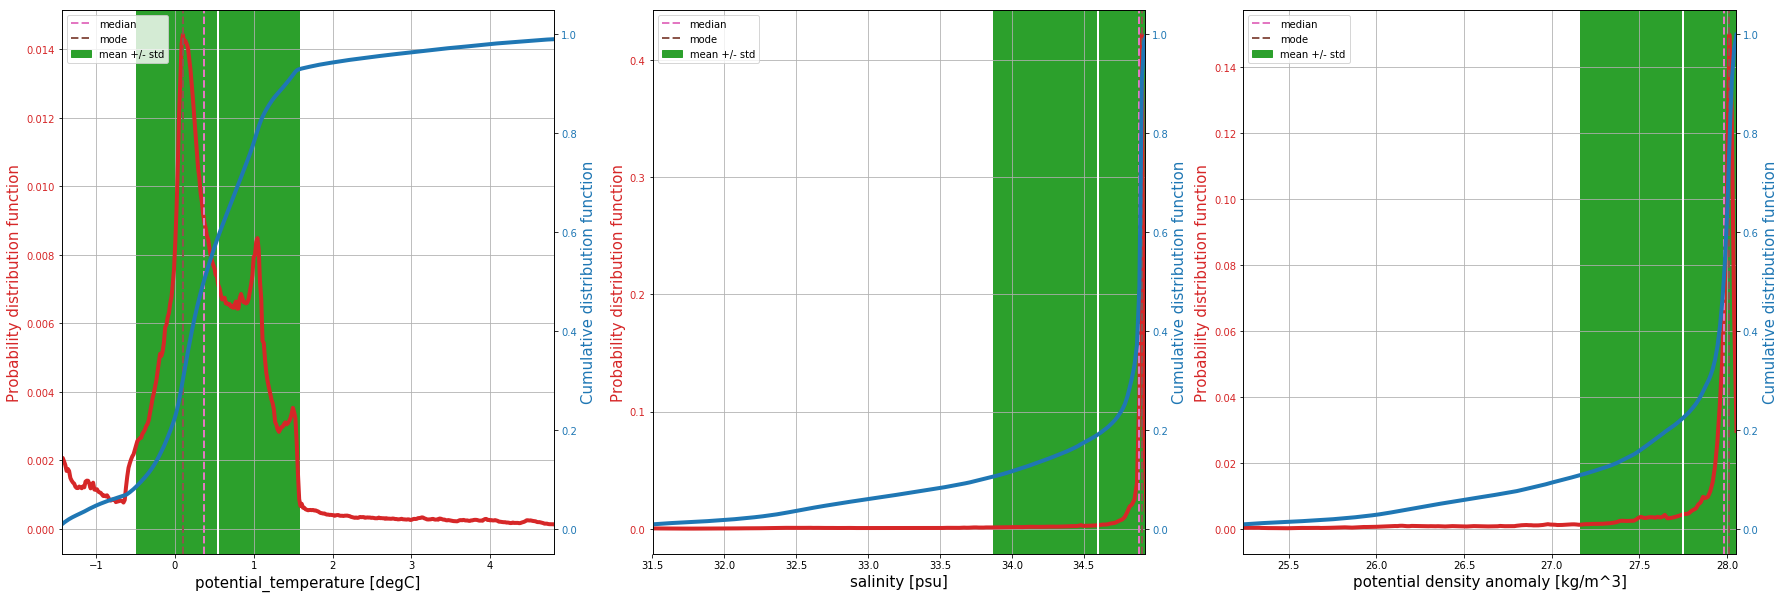

In [14]:
# Setup plotting
fig, axes = plt.subplots(1, len(var_list), figsize=(30, 10))
hist_color = 'tab:red'
qiles_color = 'tab:blue'
stat_color = 'tab:green'
stat_color2 = 'tab:cyan'
stat_color3 = 'tab:pink'
stat_color4 = 'tab:brown'
bin_edges2 = np.linspace(0, 1, 512)
qiles2 = (bin_edges2[:-1]+bin_edges2[1:])/2

# Pretty print the results:
print("Raw statistics (not volume-weighted):")
print("%25s: %10s %10s %10s %10s %10s %10s %s"
      % ('Variable', 'mean', 'std', 'mode',
         '1', '50', '99', 'percentiles'))

# Loop over variables of interest to compute std and percentiles (quantiles),
# pretty print, and plot
for i, (var, ax) in enumerate(zip(var_list, axes.flat)):

    # Print on the way to monitor progress
    var_name = od_snapshot.dataset[var].long_name
    units = od_snapshot.dataset[var].attrs['units']
    print("%25s:" % (var_name), end=" ")

    # Extract variables
    dats = getattr(od_snapshot.dataset, var)
    weights = getattr(od_snapshot.dataset, 'weight_'+var)

    # Normalize weights
    weights = weights.where(dats.notnull())
    weightsum = weights.sum()
    weights = weights/weightsum

    # Compute the arithmetic mean
    var_mean = getattr(od_snapshot.dataset, 'w_mean_'+var)
    print("%10.4g" % (var_mean), end=" ")

    # There is no OceanSpy method to compute
    # the weighted standard deviation or percentiles.

    # Compute the standard deviation
    dat2 = ((od_snapshot.dataset[var]-var_mean)**2)*weights
    var_std = np.sqrt(dat2.sum().values)
    print("%10.4g" % (var_std), end=" ")

    # Define bin edges and mid points for the variable in question.
    # We use 512 uniformly-spaced bins:
    bin_edges = np.linspace(dats.min(), dats.max(), 512)
    bin_mid = (bin_edges[:-1]+bin_edges[1:])/2

    # Compute percentiles:
    # Parallel switch
    if parallel:
        bin_snapshot_ = dask.delayed(bin_snapshot)
        # Needs to load first
        dat3 = [bin_snapshot_(dats.sel(time=time).load(),
                              weights.sel(time=time).load(),
                              bin_edges, bin_mid)
                for time in dats['time']]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dat3 = dask.compute(dat3)[0]
    else:
        dat3 = [bin_snapshot(dats.sel(time=time),
                             weights.sel(time=time), bin_edges, bin_mid)
                for time in dats['time']]

    # Concatenate dat
    dat3 = xr.concat(dat3, 'time').sum('time')
    var_hist = dat3/weights.sum()
    dat4 = dat3.cumsum()
    dat5 = dat4/weights.sum()

    # Mode
    var_mode = dat3['groups_bins'].where(dat3 == dat3.max(), drop=True)
    print("%10.4g" % (var_mode.values), end=' ')

    # Use numpy interpolation to find the percentiles
    # - effectively evaluating the inverse CDF
    var_qiles = np.interp(qiles, dat5, bin_mid)
    var_qiles2 = np.interp(qiles2, dat5, bin_mid)
    var_median = np.interp(0.50, dat5, bin_mid)
    var_limits = np.interp([0.01, 0.99], dat5, bin_mid)
    for var_qile in var_qiles:
        print("%10.4g" % (var_qile), end=" ")
    print("%s" % (units))

    # Plot the PDF
    p0 = ax.plot(bin_mid, var_hist, '-',
                 color=hist_color, label='PDF', linewidth=4)
    ax.set_xlabel(var_name+' ['+units+']', fontsize=15)
    ax.set_ylabel('Probability distribution function',
                  fontsize=15, color=hist_color)
    ax.tick_params(axis='y', labelcolor=hist_color)
    ax.grid(True)
    ax.set_xlim(var_limits)

    # Compute and plot the CDF
    ax2 = ax.twinx()
    p1 = ax2.plot(var_qiles2, qiles2, '-',
                  color=qiles_color, label='CDF', linewidth=4)
    ax2.set_ylabel('Cumulative distribution function',
                   fontsize=15, color=qiles_color)
    ax2.tick_params(axis='y', labelcolor=qiles_color)
    ax2.set_xlim(var_limits)

    # Add statistics to plot
    p2 = ax.axvspan(var_mean-var_std, var_mean+var_std, color=stat_color)
    l1 = ax.axvline(var_mean, linestyle='-', color='w', linewidth=2)
    l2 = ax.axvline(var_median, linestyle='--', color=stat_color3, linewidth=2)
    l3 = ax.axvline(var_mode, linestyle='--', color=stat_color4, linewidth=2)
    ax.legend((l2, l3, p2), ('median', 'mode', 'mean +/- std'), loc='upper left')

Notice the difference between the weighted mean statistics (in the table of numbers immediately above) and the raw statistics (further above). For example, the weighted-mean temperatures are significantly cooler. The reason is the grid cell volumes vary, which is ignored in the computation of the raw mean. 

Notice how the salinity distribution (probability density function) resembles the potential density anomaly distribution, indicating that density is controlled by salinity, not temperature. This fact is reflected in the T/S diagrams above by the nearly vertical contours of density anomaly. This is a beta-ocean in the parlance of [Carmack (2007)](https://www.sciencedirect.com/science/article/pii/S0967064507002019?via%3Dihub) and [Stewart & Haine (2016)](https://journals.ametsoc.org/doi/full/10.1175/JPO-D-16-0017.1).

Notice how the computation is accelerated using dask (try running with/without dask by setting the parallel flag at the top of this notebook).

## Volumetric census: Watch this space!

A natural extension of these concepts is to compute and plot the volumetric census over temperature/salinity classes. The plots above of probability distribution and cumulative distribution functions focus only on the variable of interest. In other words, the temperature binning to construct the histogram (`var_hist` in the code) ignores the salinity. But we're also interested in binning simultaneously into temperature and salinity classes. This quantity is (essentially) the joint probability distribution function of seawater volume over temperature and salinity. 

To compute the joint distribution of volume over temperature and salinity requires two-dimensional binning. This is a computationally-intensive task because there are many more bins to process ($512^2$, not $512$ in the example shown here). This function is under development.